-----------------Config Info-----------------
N: 10
T: 11000
T_train_val: 10000
train_ratio: 0.8
T_train: 8000
T_val: 2000
T_test: 1000
data_type: ar1
batch_size: 64
seq_length: 20
input_size: 10
output_size: 10
learning_rate: 0.001
num_epochs: 100
num_workers: 24
device: cuda
mix_precision: True
patience_epochs: 6
min_delta: 0.01
mode: min
factor: 0.1
patience_lr: 2
min_lr: 1e-06
threshold: 0.01
dg_config:
    mean_load: 50.0
    var_load: 10.0
    iid_var: 1.0
    theta: 0.9
ar_config:
    order: 5
lstm_config:
    hidden_size: 64
    num_layers: 4
gat_config:
    hidden_size: 32
    num_heads: 8
    num_gat_layers: 3
gnn_config: GNNConfig(hidden_size=32, num_layers=3)
-----------------Train and Valid Data Info-----------------
load_iid.shape: (10, 11000)
load_ar1.shape: (10, 11000)
data_type: ar1
data_np.shape: (10, 11000)
data_tensor.shape: torch.Size([10, 11000])
T: 11000
T_train: 8000
T_val: 2000
train_ratio: 0.8
T_train_val: 10000
T_test: 1000
train_val_data_np.shape: (10, 10000

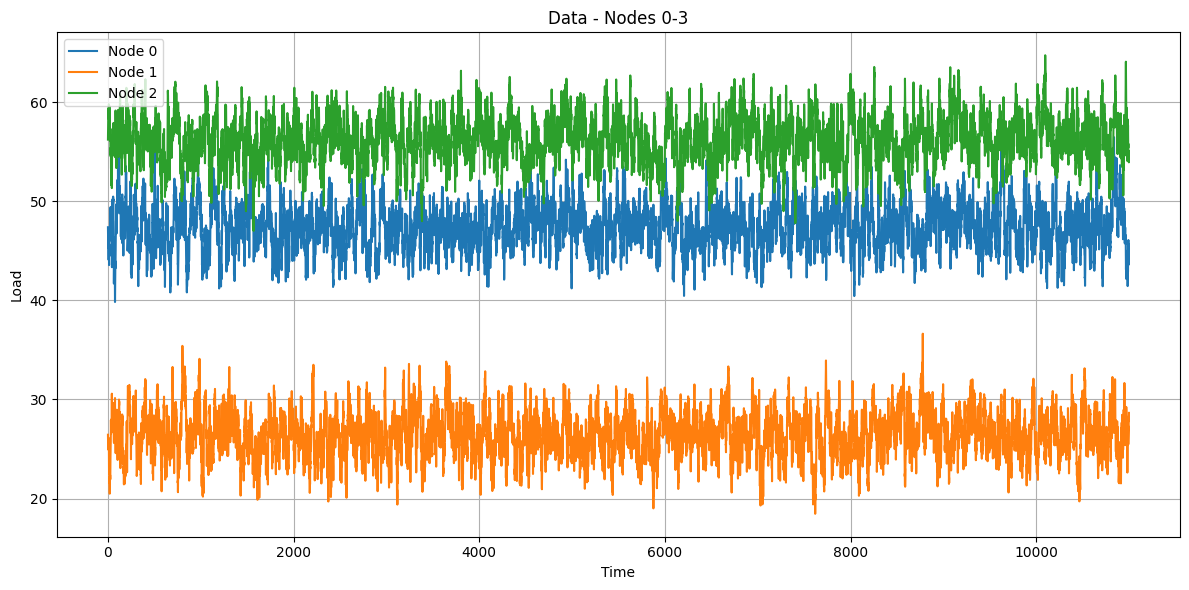

In [1]:
import torch
from Config_Data import DataGenerateConfig, ARConfig, LSTMConfig, GATConfig, GNNConfig, Process

current_config = {
    'N': 10,
    'T': 11000,
    'T_train_val': 10000,
    'T_test': 1000,
    'train_ratio': 0.8,
    'T_train': 8000,
    'T_val': 2000,
    'data_type': 'ar1',

    'batch_size': 64,
    'seq_length': 20,
    'input_size': 10,
    'output_size': 10,
    'learning_rate': 0.001,
    'num_epochs': 100,
    'num_workers': 24,
    'device': 'cuda',

    'patience_epochs': 6,
    'min_delta': 1e-2,

    'mode': 'min',
    'factor': 0.1,
    'patience_lr': 2,
    'min_lr': 1e-6,
    'threshold': 1e-2,

    'dg_config': DataGenerateConfig(mean_load=50.0, var_load=10.0, iid_var=1.0, theta=0.9),
    'ar_config': ARConfig(order=5),
    'lstm_config': LSTMConfig(hidden_size=64, num_layers=4),
    'gat_config': GATConfig(hidden_size=32, num_heads=8, num_gat_layers=3),
    'gnn_config': GNNConfig(hidden_size=32, num_layers=3)
}
# config, data_generate, data_train_val_manage = main(RE_GENERATE_DATA=True, **current_config)

config, data_manage = Process(RE_GENERATE_DATA=False, **current_config)

In [2]:
data = data_manage.data_np
data.shape


(10, 11000)

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg

In [4]:
# # 生成示例数据
# np.random.seed(42)
# n = 100
# time_series_data = np.cumsum(np.random.randn(n)) + 20 * np.sin(np.linspace(0, 10, n))
# 
# # 拟合 AutoReg 模型
# order = 5
# model = AutoReg(time_series_data, lags=order, hold_back=order).fit()
# 
# # 预测未来 20 个时间点，dynamic=False 和 dynamic=True 的对比
# forecast_steps = 50
# pred_dynamic_false = model.predict(start=n - forecast_steps + 1, end=n, dynamic=False)
# pred_dynamic_true = model.predict(start=n - forecast_steps + 1, end=n, dynamic=True)
# 
# # 绘制结果对比
# plt.figure(figsize=(14, 7))
# 
# # 绘制真实数据
# plt.plot(np.arange(n), time_series_data, label='Original Data')
# 
# # 绘制 dynamic=False 的预测结果
# plt.plot(np.arange(n - forecast_steps, n), pred_dynamic_false, label='Dynamic=False Prediction', linestyle='--',
#          marker='o')
# 
# # 绘制 dynamic=True 的预测结果
# plt.plot(np.arange(n - forecast_steps, n), pred_dynamic_true, label='Dynamic=True Prediction', linestyle='--',
#          marker='x')
# 
# plt.title('Comparison of AR Model Predictions with Dynamic=False and Dynamic=True')
# plt.xlabel('Time')
# plt.ylabel('Value')
# plt.legend()
# plt.grid(True)
# plt.show()


In [5]:
class ARExpert:
    """
    AR专家，每次预测后都会使用全部的历史数据（而不是移动窗口）更新模型，然后再进行预测
    
    参数:
    - data: ndarray, 每行代表一个节点的负载数据， shape 为 (N, T_train + T_test)
    - order: int, AR模型的阶数
    """

    def __init__(self, config, data_manage):
        self.config = config
        self.data_manage = data_manage
        
        self.N = self.config.N
        self.data = self.data_manage.data_np
        self.order = self.config.ar_config.order  # AR 模型的阶数
        self.T = self.config.T
        self.T_train_val = self.config.T_train_val
        self.T_train = self.config.T_train
        self.T_val = self.config.T_val
        self.T_test = self.config.T_test
        
        self.train_val_data = self.data_manage.train_val_data_np
        self.test_data = self.data_manage.test_data_np

        # 预先分配 joint_train_data 的空间
        self.joint_train_data = np.zeros(( self.N, self.T_train_val + self.T_test))
        # 将训练验证数据填充到 joint_train_data 中
        self.joint_train_data[:, :self.T_train_val] = self.train_val_data

        # 为每个节点训练一个 AR 模型
        self.models = [
            AutoReg(self.joint_train_data[i, :self.T_train_val], lags=self.order).fit() for i in
            range( self.N)]

        self.predictions = np.zeros(( self.N, self.T_test))  # 存储每次的预测结果
        self.true_values = np.zeros(( self.N, self.T_test))  # 存储每次的真实数据
        self.losses = np.zeros(( self.N, self.T_test))  # 存储每次的损失

    def predict_and_update(self):

        for t in range(self.T_test):
            print(f't={t}, joint_train_data.shape={self.joint_train_data.shape}')

            # 预测
            predictions = [self.models[i].predict(start=self.T_train_val + t, end=self.T_train_val + t)
                           for i in range( self.N)]
            self.predictions[:, t] = np.array(predictions).flatten()

            if t < self.T_test - 1:
                # 获取真实值并更新 joint_train_data
                self.true_values[:, t] = self.test_data[:, t]
                self.joint_train_data[:, self.T_train_val + t] = self.true_values[:, t]

                # 更新所有节点的模型
                self.models = [AutoReg(self.joint_train_data[i, :self.T_train_val + t + 1],
                                       lags=self.order).fit() for i in range( self.N)]

            else:
                self.true_values[:, t] = self.test_data[:, t]

        self.losses = self.compute_loss(np.array(self.predictions), np.array(self.true_values))
        return self.predictions, self.true_values, self.losses

    def compute_loss(self, predictions, true_values):
        return np.mean((predictions - true_values) ** 2, axis=0)

    def get_predictions(self):
        return self.predictions

    def get_true_values(self):
        return self.true_values

    def get_losses(self):
        return self.losses

    def plot_losses(self):
        plt.figure(figsize=(10, 6))
        plt.plot(self.losses, label='Loss')
        plt.title('Prediction Loss over Time')
        plt.xlabel('Time Step')
        plt.ylabel('Mean Squared Error')
        plt.legend()
        plt.grid(True)
        plt.show()

    def plot_predictions(self, node_index, start=0, end=11000):
        plt.figure(figsize=(10, 6))

        # 绘制真实数据
        if start < self.T_train_val:
            plt.plot(range(start, min(end, self.T_train_val)),
                     self.train_val_data[node_index][start:min(end, self.T_train_val)],
                     label='True Data (Train)')
        if end > self.T_train_val:
            plt.plot(range(max(start, self.T_train_val), end), self.test_data[node_index][max(0,
                                                                                                                 start - self.T_train_val):end - self.T_train_val],
                     label='True Data (Test)')

        # 绘制预测数据
        plt.plot(range(max(self.T_train_val, start), min(end, self.T_train_val + self.T_test)),
                 self.predictions[node_index][
                 max(0, start - self.T_train_val):min(end - self.T_train_val, self.T_test)],
                 label='Predictions', linestyle='--')

        plt.title(f'Predictions for Node {node_index}')
        plt.xlabel('Time Step')
        plt.ylabel('Load')
        plt.legend()
        plt.grid(True)
        plt.show()

In [6]:
%%time
# 创建 ARExpert 对象并执行预测与更新
ar_expert = ARExpert(config, data_manage)
predictions, true_values, losses = ar_expert.predict_and_update()
losses.sum()

t=0, joint_train_data.shape=(10, 11000)
t=1, joint_train_data.shape=(10, 11000)
t=2, joint_train_data.shape=(10, 11000)
t=3, joint_train_data.shape=(10, 11000)
t=4, joint_train_data.shape=(10, 11000)
t=5, joint_train_data.shape=(10, 11000)
t=6, joint_train_data.shape=(10, 11000)
t=7, joint_train_data.shape=(10, 11000)
t=8, joint_train_data.shape=(10, 11000)
t=9, joint_train_data.shape=(10, 11000)
t=10, joint_train_data.shape=(10, 11000)
t=11, joint_train_data.shape=(10, 11000)
t=12, joint_train_data.shape=(10, 11000)
t=13, joint_train_data.shape=(10, 11000)
t=14, joint_train_data.shape=(10, 11000)
t=15, joint_train_data.shape=(10, 11000)
t=16, joint_train_data.shape=(10, 11000)
t=17, joint_train_data.shape=(10, 11000)
t=18, joint_train_data.shape=(10, 11000)
t=19, joint_train_data.shape=(10, 11000)
t=20, joint_train_data.shape=(10, 11000)
t=21, joint_train_data.shape=(10, 11000)
t=22, joint_train_data.shape=(10, 11000)
t=23, joint_train_data.shape=(10, 11000)
t=24, joint_train_data.sha

1019.3310106880552

In [7]:
ar_expert.get_predictions().shape

(10, 1000)

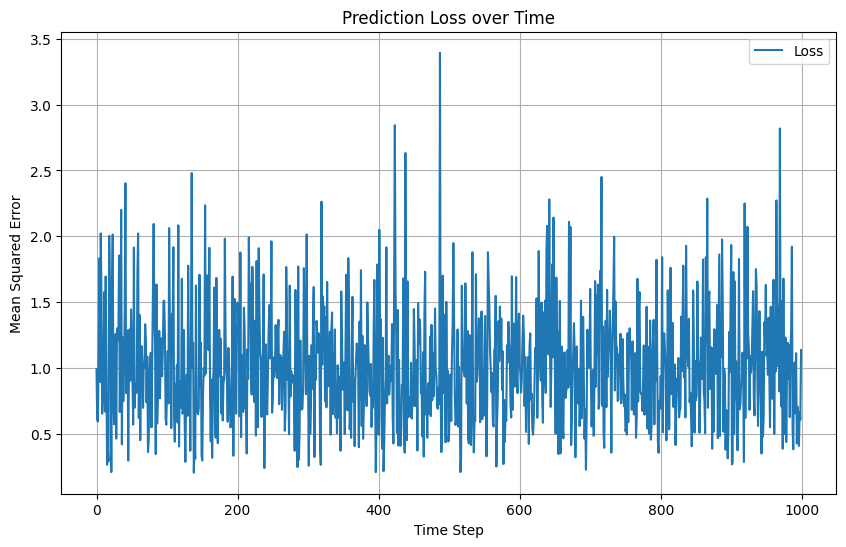

In [8]:
# 绘制损失
ar_expert.plot_losses()

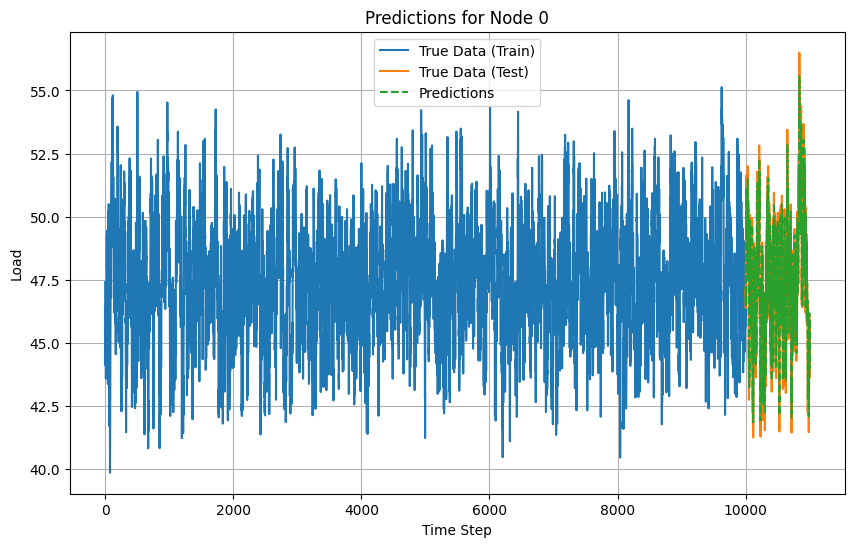

In [9]:
# 绘制预测结果
ar_expert.plot_predictions(node_index=0)


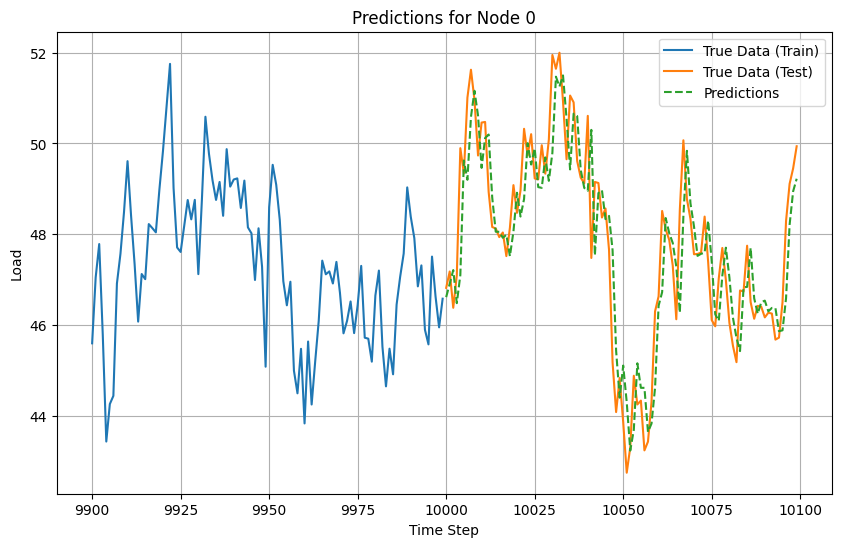

In [10]:
ar_expert.plot_predictions(node_index=0, start=9900, end=10100)

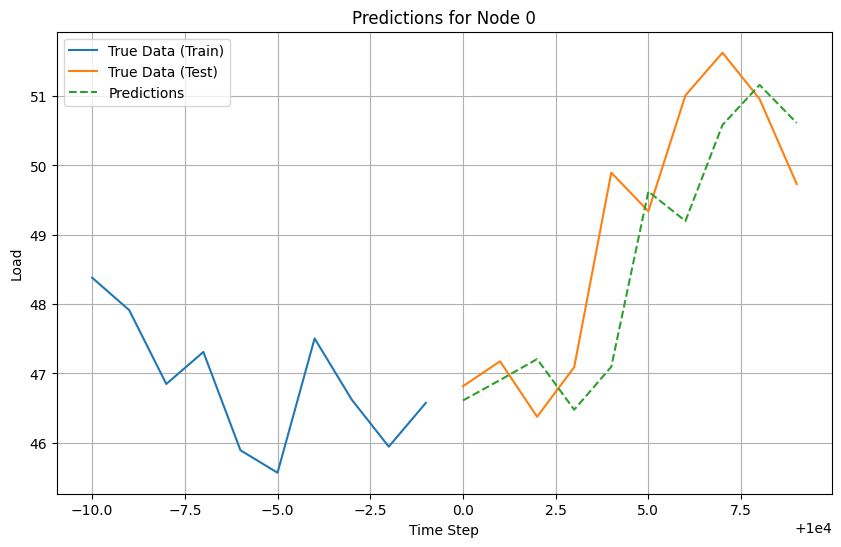

In [11]:
ar_expert.plot_predictions(node_index=0, start=9990, end=10010)

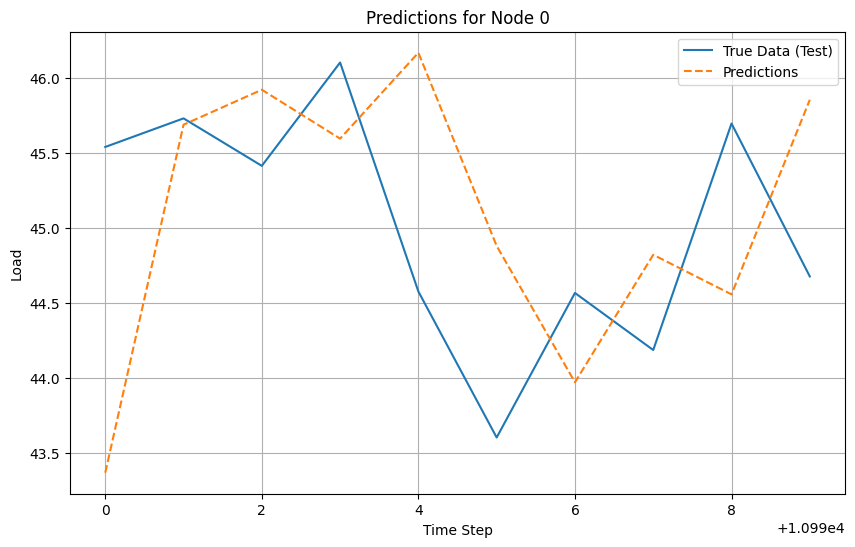

In [12]:
ar_expert.plot_predictions(node_index=0, start=10990, end=11000)

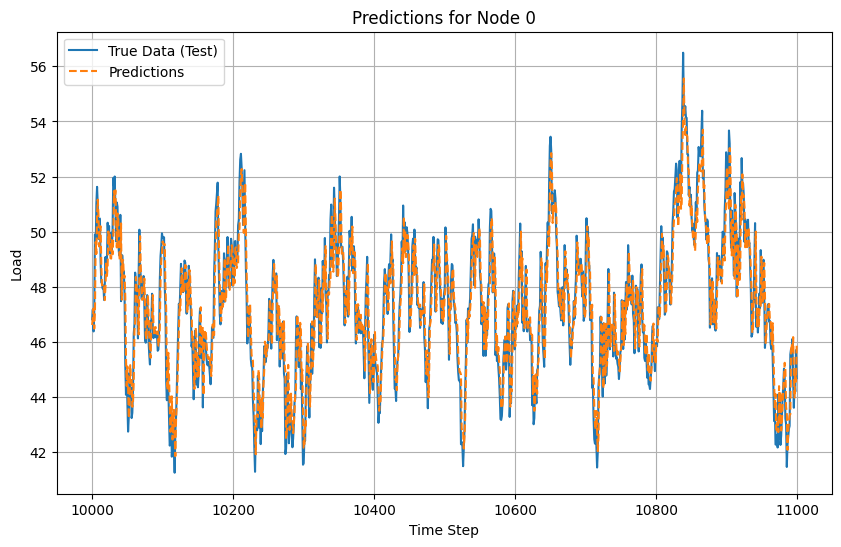

In [13]:
ar_expert.plot_predictions(node_index=0, start=10000, end=11000)